# Arbori de decizie. Păduri aleatoare
* Tudor Berariu - 2016
* George Muraru - 2020
* Florin Dumitrescu - 2024


## Scopul laboratorului

Scopul acestui laborator îl reprezintă înțelegerea și implementarea arborilor de decizie a pădurilor de arbori aleatori.

În prima parte a laboratorului veți implementa un arbore de decizie folosind algoritmul ID3 pentru construirea arborelui și măsurarea entropiei pentru alegerea atributului care oferă cel mai mare câștig informațional.

În a doua parte a laboratorului veți implementa un clasificator de tip pădure de arbori aleatori, care va fi comparat
 cu un arbore de decizie simplu.

## Problema de rezolvat

Problema de rezolvat ı̂n acest laborator este una de ı̂nvățare supervizată: fiind dat un **set de date X** ce conține exemple descrise printr-un set de **atribute discrete A** și etichetate cu **câte o clasă dintr-o mulțime cunoscută C**, să se construiască un model pentru clasificarea exemplelor noi.

### Păduri de arbori aleatori

*Pădurile de arbori aleatori* (eng. Random Forest) este un model format din mai mulți arbori de decizie.

Se bazează pe 2 hiperparametrii:
* Eșantionare aleatoare din setul de date de antrenament
* Subseturi aleatoare de atribute considerate la împărțirea pe mai multi subarbori

Predicția, utilizând un astfel de model, se bazează pe clasa majoritară oferită de predicțiile indepente ale tuturor arborilor.

### Seturi de date folosite

Pentru acest laborator vom folosi urmatoarele seturi de date pentru antrenarea și testarea algoritmilor 
implementați:
* [Car Evaluation](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation)
* [Tennis](https://www.kaggle.com/fredericobreno/play-tennis)
* [Chess](https://archive.ics.uci.edu/dataset/22/chess+king+rook+vs+king+pawn)

Seturile de date sunt disponibile în folderul `datasets` sub forma unor fișiere cu extensia `.csv`

#### Car Evaluation

Setul de date *Car Evaluation* conține informații despre caracteristicile unui autovehicul și clasa de evaluare a acestuia. Atributele sunt următoarele:

&nbsp;

| Nume atribut | Valori atribut           | Explicație                 |
|--------------|--------------------------|----------------------------|
| buying       | v-high, high, med, low   | prețul de cumpărare        |
| maint        | v-high, high, med, low   | costul întreținerii        |
| doors        | 2, 3, 4, 5-more          | numărul de uși             |
| persons      | 2, 4, more               | capacitatea de transport   |
| lug_boot     | small, med, big          | dimensiunea portbagajului  |
| safety       | low, med, high           | nivelul de siguranță       |


Clasa pe care trebuie să o prezicem este `class` și poate avea următoarele valori: 
  * `unacc`
  * `acc`
  * `good`
  * `v-good`

#### Tennis
Setul de date *Tennis* conține informații despre caracteristicile unei zile și dacă se poate juca tenis sau nu. Atributele sunt următoarele:

&nbsp;

| Nume atribut | Valori atribut        |
|--------------|-----------------------|
| Outlook      | sunny, overcast, rain |
| Temperature  | hot, mild, cool       |
| Humidity     | high, normal          |
| Windy        | true, false           |

Clasa pe care trebuie să o prezicem este `Play` și poate avea următoarele valori:
  * `yes`
  * `no`
#### Chess
Setul de date *Chess* conține informații despre o poziție de șah și dacă jucătorul care a făcut ultima mutare a câștigat sau nu. Nu se va intra în detalii despre semnificația atributelor setului de date, acestea fiind folosite doar pentru a exemplifica construcția unui arbore de decizie.
Atributele sunt următoarele:

&nbsp;

| Attribute Name | Possible Values | Attribute Name | Possible Values |
|----------------|-----------------|----------------|-----------------|
| bkblk          | f, t            | bknwy          | f, t            |
| bkon8          | f, t            | bkona          | f, t            |
| bkspr          | t, f            | bkxbq          | f, t            |
| bkxcr          | t, f            | bkxwp          | t, f            |
| blxwp          | t, f            | bxqsq          | f, t            |
| cntxt          | f, t            | dsopp          | f, t            |
| dwipd          | l, g            | hdchk          | f, t            |
| katri          | n, w, b         | mulch          | f, t            |
| qxmsq          | f, t            | r2ar8          | f, t            |
| reskd          | f, t            | reskr          | f, t            |
| rimmx          | f, t            | rkxwp          | f, t            |
| rxmsq          | f, t            | simpl          | t, f            |
| skach          | f, t            | skewr          | t, f            |
| skrxp          | f, t            | spcop          | f, t            |
| stlmt          | f, t            | thrsk          | f, t            |
| wkcti          | f, t            | wkna8          | f, t            |
| wknck          | f, t            | wkovl          | t, f            |
| wkpos          | t, f            | wtoeg          | n, t            |

&nbsp;

Clasa pe care trebuie să o prezicem este `class` și poate avea următoarele valori:
  * `won`
  * `nowin`
  
##### Atenție!
Nu este indicată utilizarea acestui set de date decât pentru evaluarea performanței algoritmilor implementați. Acesta este un set de date complex, cu multe atribute, care este mai greu de interpretat în momentul construirii arborelui de decizie.

## Câteva biblioteci de care vom avea nevoie

In [1]:
# Decomentați următoarele linii dacă nu aveți deja instalate bibliotecile
#!pip install numpy
#!pip install pandas
#!pip install tqdm
#!pip install matplotlib
#!pip install seaborn
#!pip install graphviz

In [2]:
from __future__ import annotations  # Necesar pentru a folosi tipul clasei în definiția ei
from typing import Optional, Dict, Callable
from pathlib import Path
from copy import deepcopy
from collections import Counter

import pandas as pd  # Pentru a citi si afisa datele
import numpy as np
from graphviz import Digraph, Source  # Pentru a vizualiza arborele de decizie
from IPython.display import display as idisplay  # Pentru a afisa arborele de decizie direct în celulă
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

## Scurtă introducere în biblioteca pandas

Pentru a citi datele dintr-un fișier `.csv` vom folosi biblioteca `pandas`. Aceasta oferă o structură de date tabulară numită `DataFrame` care ne permite să lucrăm cu datele într-un mod simplu și eficient. Pentru a citi datele dintr-un fișier `.csv` vom folosi funcția `pd.read_csv()`.

Un `DataFrame` este o structură de date bidimensională, cu date organizate în coloane, care pot avea tipuri de date diferite. Fiecare coloană sau rând dintr-un `DataFrame` este un obiect de tip `pd.Series`, care este un vector unidimensional.

In [3]:
# Exemplu de creare a unui DataFrame
data = {
    'Name': ['Alice', 'Bob', 'Charlie', 'David'],
    'Age': [25, 30, 35, 40],
    'City': ['Cluj-Napoca', 'București', 'Iași', 'Timișoara']
}

df = pd.DataFrame(data)
print(df)

      Name  Age         City
0    Alice   25  Cluj-Napoca
1      Bob   30    București
2  Charlie   35         Iași
3    David   40    Timișoara


Aceasta va afișa:

```
      Name  Age         City
0    Alice   25  Cluj-Napoca
1      Bob   30    București
2  Charlie   35         Iași
3    David   40   Timișoara
```

Pentru a accesa o coloană dintr-un `DataFrame` putem folosi `df['NumeColoană']` sau `df.NumeColoană`:

In [4]:
# Exemplu de accesare a unei coloane dintr-un DataFrame folosind df['NumeColoană']
print(df['Name'])

0      Alice
1        Bob
2    Charlie
3      David
Name: Name, dtype: object


In [5]:
# Exemplu de accesare a unei coloane dintr-un DataFrame folosind df.NumeColoană
print(df.Name)

0      Alice
1        Bob
2    Charlie
3      David
Name: Name, dtype: object


Coloana `df['Name']` va fi un obiect de tip `pd.Series`:

In [6]:
print(type(df['Name']))

<class 'pandas.core.series.Series'>


Pentru a accesa o linie dintr-un `DataFrame` putem folosi `df.iloc[linie]`:


In [7]:
# Exemplu de accesare a unei linii dintr-un DataFrame folosind df.iloc[linie]
print(df.iloc[0])

Name          Alice
Age              25
City    Cluj-Napoca
Name: 0, dtype: object


Linia `df.iloc[0]` va fi un obiect de tip `pd.Series`:

In [8]:
print(type(df.iloc[0]))

<class 'pandas.core.series.Series'>


Diferența dintre un obiect de tip `pd.Series` și un obiect de tip `pd.DataFrame` este că un `pd.Series` este un vector unidimensional, în timp ce un `pd.DataFrame` este o structură de date bidimensională. Pentru a accesa un element dintr-un `pd.Series` putem folosi `pd.Series[index]`:

In [9]:
# Exemplu de accesare a unui element dintr-un pd.Series folosind pd.Series[index]
df_name_series = df['Name']
print(df_name_series[0])

Alice


Analog, pentru a accesa un element dintr-un `pd.DataFrame` putem folosi mai multe metode:
* `df[coloană][linie]`
* `df.loc[linie, coloană]`
* `df.iloc[linie, coloană]`

Diferența dintre `df.loc[linie, coloană]` și `df.iloc[linie, coloană]` este că `df.loc[linie, coloană]` folosește numele coloanelor, în timp ce `df.iloc[linie, coloană]` folosește indicii numerici ai coloanelor.

**Întrebare**: Ce se întâmplă dacă folosim `df[coloană, linie]`?

Se va arunca o excepție de tip `KeyError` deoarece `df[coloană, linie]` nu este o metodă validă de accesare a unui element dintr-un `DataFrame`.

In [10]:
# Exemplu de accesare a unui element dintr-un DataFrame
print(f"{df['Name'][0] =}")
print(f"{df.loc[0, 'Name'] =}")
print(f"{df.iloc[0, 0] =}")

df['Name'][0] ='Alice'
df.loc[0, 'Name'] ='Alice'
df.iloc[0, 0] ='Alice'


Accesarea mai multor linii sau coloane dintr-un `DataFrame` se poate face folosind `df.loc[linie_start:linie_stop, coloană_start:coloană_stop]` sau `df.iloc[linie_start:linie_stop, coloană_start:coloană_stop]`:

In [11]:
# Exemplu de accesare a mai multor linii sau coloane dintr-un DataFrame
print(df.loc[0:2, 'Name':'Age'])

      Name  Age
0    Alice   25
1      Bob   30
2  Charlie   35


Pentru a extrage doar valorile care corespund unei condiții putem folosi `df[df['NumeColoană'] == valoare]`:

In [12]:
# Exemplu de extragere a valorilor care corespund unei condiții dintr-un DataFrame
print(df[df['Age'] > 30])

      Name  Age       City
2  Charlie   35       Iași
3    David   40  Timișoara


Analog, putem obține doar valorile care corespund mai multor condiții folosind `df[(df['NumeColoană1'] == valoare1) & (df['NumeColoană2'] == valoare2)]`:

In [13]:
# Exemplu de extragere a valorilor care corespund mai multor condiții dintr-un DataFrame
print(df[(df['Age'] > 30) & (df['City'] == 'Timișoara')])

    Name  Age       City
3  David   40  Timișoara


O altă funcționalitate utilă a bibliotecii a folosirii obiectelor de tip `DataFrame` sau `Series` este că acestea ne oferă metode prin care să putem compara 2 vectori și să returnăm doar acele intrări (rânduri) care sunt comune între cei doi vectori. Această funcționalitate este utilă când dorim să calculăm metricile de evaluare ale unui model de clasificare, putând compara predicțiile modelului cu etichetele reale ale setului de date. În mod implicit se păstrează indexul rândurilor care sunt identice între cei doi vectori.

In [14]:
# Definim 2 obiecte de tip Series
y_true = pd.Series(['a', 'b', 'd', 'd', 'e'])
y_pred = pd.Series(['a', 'b', 'c', 'f', 'e'])

# Obținem doar valorile care sunt prezente în ambele obiecte
common_values = y_true[y_true == y_pred]
print(common_values)

0    a
1    b
4    e
dtype: object


## Definirea constantelor și a hiperparametrilor

In [15]:
DATASET_ROOT = 'res-id3'  # directorul în care se află seturile de date
DATASET_NAME = 'tennis'    # @param ['car', 'tennis', 'chess']

# Adâncimea maxima a arborilor
MAX_DEPTH = 3 #@param {type: "slider", min: 1, max: 9999}

# Procentul de exemple din setul de date utilizat la construcția arborilor
MIN_SAMPLES_PER_NODE = 2  #@param {type: "slider", min: 2, max: 100}

# Numele atributului care reprezintă clasa
if DATASET_NAME in ['car', 'chess']:
    TARGET_FEATURE = 'class'
elif DATASET_NAME == 'tennis':
    TARGET_FEATURE = 'Play'
else:
    raise ValueError(f"Unknown dataset {DATASET_NAME}")

## Seturi de date

Seturile de date folosite sunt disponibile în folderul `datasets` sub forma unor fișiere cu extensia `.csv`. Acestea 
sunt citite și încărcate în memorie folosind biblioteca `pandas`, care oferă o structură de date tabulară numită 
`DataFrame`.

Din punct de vedere al notației, setul de date este reprezentat astfel:
* $X$ &rarr; atributele setului de date, reprezentate sub forma unui tabel cu $n$ linii și $m$ coloane, unde $n$ reprezintă numărul de exemple, iar $m$ numărul de atribute
* $y$ &rarr; clasele (etichetele) setului de date, reprezentate sub forma unui vector cu $n$ elemente, unde $n$ reprezintă numărul de exemple

In [16]:
def load_dataset(dataset_filename: str) -> pd.DataFrame:
    """
    Incarca in memorie un set de date
    
    Args:
        dataset_filename (str): 
            Numele fisierului ce contine setul de date (cu tot cu extensie)
     
    Returns:
        pd.DataFrame: 
            Un DataFrame pandas ce contine setul de date
    """
    print (f"Dataset: {dataset_filename}")

    dataset_path = Path(DATASET_ROOT) / dataset_filename
    
    if not dataset_path.exists():
        raise FileNotFoundError(f"Dataset {dataset_filename} not found at {dataset_path}")
    return pd.read_csv(dataset_path)

def display_dataset(dataset: pd.DataFrame):
    """
    Afiseaza primele 5 intrări din setul de date
    
    Args:
        dataset (pd.DataFrame): 
            Setul de date in format pandas DataFrame.
    """
    print(dataset.head(n=5))
    
def display_dataset_feature_values(dataset: pd.DataFrame, feature: str):
    """
    Afiseaza valorile distincte ale unui atribut din setul de date
    
    Args:
        dataset (pd.DataFrame):
            Setul de date in format pandas DataFrame.
        feature (str):
            Numele atributului pentru care se vor afisa valorile distincte.
    """
    print(dataset[feature].unique())
    
def split_dataset(dataset: pd.DataFrame, target_feature: str) -> (pd.DataFrame, pd.Series):
    """
    Imparte setul de date in atribute si clase (etichete). In cazul seturilor noastre de date, ultima coloana reprezinta intotdeauna clasa.
    
    Args:
        dataset (pd.DataFrame): 
            Setul de date in format pandas DataFrame.
        target_feature (str): 
            Numele atributului care reprezinta clasa.
        
    Returns:
        tuple(pd.DataFrame, pd.Series): 
            Un tuplu ce contine atributele si clasele setului de date in formatul (X, y)
    """    
    return dataset.drop(columns=[target_feature]), dataset[target_feature]

def split_train_test(dataset: pd.DataFrame, 
                     target_feature: str, 
                     test_size: float = 0.2) -> (pd.DataFrame, pd.Series, 
                                                 pd.DataFrame, pd.Series):
    """
    Splits the dataset into a training set and a testing set.

    Args:
        dataset (pd.DataFrame): 
            Setul de date in format pandas DataFrame.
        target_feature (str): 
            Numle atributului care reprezinta clasa.
        test_size (float, optional): 
            Proportia setului de date care va fi folosita pentru testare. Defaults to 0.2.

    Returns:
        tuple(pd.DataFrame, pd.Series, pd.DataFrame, pd.Series): 
            Un tuplu ce contine atributele si clasele setului de date de antrenare si de testare in formatul 
            (X_train, y_train, X_test, y_test)
    """
    from sklearn.model_selection import train_test_split
    
    # Imparte setul de date in set de antrenare si set de testare
    train_set, test_set = train_test_split(dataset, test_size=test_size, shuffle=True)
    
    # Imparte setul de date in atribute si clase
    X_train_, y_train_ = split_dataset(train_set, target_feature)
    X_test_, y_test_ = split_dataset(test_set, target_feature)

    return X_train_, y_train_, X_test_, y_test_

### Pregătire set de date

In [17]:
# Se incarca setul de date si se afiseaza primele 5 inregistrari
data = load_dataset(DATASET_NAME)
display_dataset(data)

Dataset: tennis
    Outlook Temperature Humidity  Windy Play
0     sunny         hot     high  False   no
1     sunny         hot     high   True   no
2  overcast         hot     high  False  yes
3      rain        mild     high  False  yes
4      rain        cool   normal  False  yes


In [23]:
# Se afiseaza clasele distincte ale setului de date
print("Classes: ", end="\n\t")
display_dataset_feature_values(data, TARGET_FEATURE)

# Se afiseaza valorile distincte ale fiecarui atribut din setul de date
for feature_name in data.columns:
    print(f"Attribute: {feature_name}", end="\n\t")
    display_dataset_feature_values(data, feature_name)

Classes: 
	['no' 'yes']
Attribute: Outlook
	['sunny' 'overcast' 'rain']
Attribute: Temperature
	['hot' 'mild' 'cool']
Attribute: Humidity
	['high' 'normal']
Attribute: Windy
	[False  True]
Attribute: Play
	['no' 'yes']


In [24]:
# Se imparte setul de date in set de date de antrenare si set de date de testare
X_train, y_train, X_test, y_test = split_train_test(data, target_feature=TARGET_FEATURE)

print(f"Setul de antrenare conține {len(X_train)} exemple")
print(f"Setul de testare conține {len(X_test)} exemple")

Setul de antrenare conține 11 exemple
Setul de testare conține 3 exemple


## Arbore de decizie

Un arbore de decizie este un clasificator ce aproximează funcții discrete.

Într-un arbore de decizie există 2 tipuri de noduri:
* *noduri intermediare* - conține un test pentru un atribut și are câte un arc (și implicit un subarbore) pentru fiecare valoare posibiliă a atributului
* *noduri frunză* - este etichetat cu o clasă

Pentru **a clasifica un obiect nou** se pornește din rădăcina arborelui și din fiecare nod se coboară pe arcul corespunzător valorii atributului pe care o are obiectul dat. Atunci când se ajunge ı̂ntr-un nod frunză, clasa acestuia va reprezenta predicția arborelui.

In [25]:
class DecisionTreeNode:
    """
    Un nod din arborele de decizie. Acesta poate fi un nod intermediar sau un nod frunză.
    """
    
    def __init__(self, 
                 feature: Optional[str] = None, 
                 children: Optional[Dict[str, DecisionTreeNode]] = None, 
                 label: Optional[str] = None):
        """
        Constructor pentru un nod din arborele de decizie
        
        Args:
            feature (str, optional): 
                Numele atributului după care se face împărțirea. Defaults to None.
            children (Dict[str, DecisionTreeNode], optional): 
                Un dictionar ce conține subarborii nodului curent. Defaults to None.
            label (str, optional): 
                Clasa nodului frunză. Defaults to None.
        """
        self.split_feature = feature  # Numele atributului după care se face împărțirea (None pentru nodurile frunză)
        self.children = children if (children is not None and feature is not None) else {}
        self.label = label    # Clasa nodului frunză (None pentru nodurile intermediare)
        self.depth = 1        # Adâncimea nodului în arbore (se calculează în timpul construcției arborelui)
        self.score = 0        # Scorul nodului (se calculează în timpul construcției arborelui)
        self.num_samples = 0  # Numărul de exemple din setul de date care ajung în nodul curent
    
    def get_tree_graph(self,
                       graph: Digraph = None) -> Digraph:
        """
        Construiește reprezentarea grafică a arborelui de decizie folosind biblioteca Graphviz
    
        Args:
            graph (Digraph, optional): 
                Obiectul Digraph în care se construiește reprezentarea arborelui. Defaults to None.
        """
        if graph is None:
            graph = Digraph()
            graph.attr('node', shape='box')
    
        if self.split_feature is None:
            # Nod frunză
            graph.node(f"{self}", f"Label: {self.label}\n"
                                  f"Score: {self.score:.3f}\n"
                                  f"Samples: {self.num_samples}", 
                       fillcolor='darkolivegreen2', style='filled')
        else:
            # Nod intermediar
            graph.node(f"{self}", f"Split: {self.split_feature}?\n"
                                  f"Score: {self.score:.3f}\n"
                                  f"Samples: {self.num_samples}", fillcolor='lightblue', style='filled')
            
            for value, child in self.children.items():
                child.get_tree_graph(graph)
                graph.edge(f"{self}", f"{child}", label=f"{value}")
    
        return graph
    
    def display(self):
        """
        Afișează arborele de decizie folosind biblioteca Graphviz. Arborele va fi afișat ca output al celulei.
        """
        graph = self.get_tree_graph()
        idisplay(Source(graph.source))

#### Exemplu de utilizare a clasei DecisionTreeNode

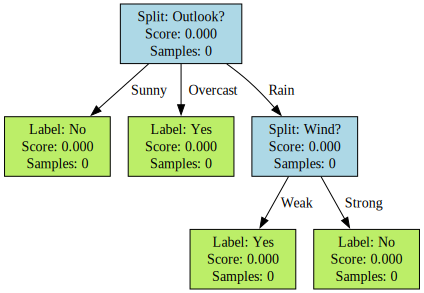

In [26]:
# Se creează rădăcina arborelui, care are ca atribut de împărțire "Outlook"
root = DecisionTreeNode(feature="Outlook")

# Se adaugă subarborii rădăcinii
root.children = {
    "Sunny": DecisionTreeNode(label="No"),
    "Overcast": DecisionTreeNode(label="Yes"),
    "Rain": DecisionTreeNode(feature="Wind")
}

# Se adaugă subarborii nodului corespunzător valorii "Rain"
root.children["Rain"].children = {
    "Weak": DecisionTreeNode(label="Yes"),
    "Strong": DecisionTreeNode(label="No")
}

# Se afișează arborele de decizie
root.display()

### Construirea arborelui de decizie

* Dacă toate exemplele din $X$ aparțin unei singure clasă $C$, atunci se construiește un nod frunză etichetat cu acea clasă $C$
* Dacă nu mai există atribute sau s-a îndeplinit un criteriu de oprire, atunci construiește nodul frunză etichetat cu cea mai frecventă clasă din $X$
* În caz contrar:
  * Se alege atributul $a^*$ din lista de atribute $A$ care încă nu a fost folosit (conform unui criteriu de 
  selecție) 
  * Pentru fiecare valoare posibilă $v_j$ a lui $a^*$ se construiește un subarbore:
    * Se construiește submulțimea de exemple $X_{i/j}$ care au valoarea $v_j$ pentru atributul $a^*$: 
        $X_{i/j} = \{x \in X|a_{i}(x) = v_j\}$
    * Se construiește submulțimea de atribute $A_{new}$ care nu mai conține atributul $a^*$:  $A_{new} = A \setminus \{a_i\}$
    * Se apelează recursiv funcția de construire a arborelui pentru submulțimea de exemple $X_{i/j}$ și submulțimea de atribute $A_{new}$
    * Se adaugă subarborele construit la nodul curent

#### Random Tree

Algoritmul Random Tree este un mod simplu de a construi un arbore de decizie. În acest caz, la fiecare pas se alege 
aleator un atribut după care se face împărțirea:

$$ a^* = random\_choice(A) $$

#### Algoritmul ID3

Algoritmul ID3 (Iterative Dichotomiser 3) este un algoritm folosit pentru construirea arborilor de decizie prin 
alegerea atributului care oferă cel mai mare câștig informațional la fiecare pas.
 
Formula de calcul a câștigului informațional este dată de:

  $$
    entropy(X) = -\sum_{c \in C}\frac{|X_c|}{|X|}log_2\frac{|X_c|}{|X|}
  $$
  $$
    gain(X, a_i) = entropy(X) - \sum_{v_{j} \in vals(a_i)} \frac{|X_{i/j}|}{|X|}entropy(X_{i/j})
  $$
  $$
    a^* = \underset{a_i \in A}{\operatorname{arg max}}\ gain(X, a_i)
  $$

În cazul prezentat mai sus, entropia este utilizată pentru a măsura randomness-ul din date. Intuitiv, cu cât un eveniment are probabilitate mai mare să se întâmple atunci acesta va avea o entropia din ce în ce mai mică. Prin modul în care se construiește arborele *ID3* se încearcă reducerea entropiei alegând la fiecare pas atributele care ne ofera cea mai multă informație. 

**Întrebare**:
Cât considerați că este entropia într-un *nod frunză*?

In [88]:
class DecisionTree:
    """
    Clasa care implementează un arbore de decizie. 
    Arborele poate fi construit folosind algoritmul ID3 sau Random Tree, în funcție de strategia de împărțire specificată.
    """
    def __init__(self,
                 split_strategy: str = 'random',
                 max_depth: int = np.inf,
                 min_samples_per_node: int = 1):
        """
        Constructor pentru un arbore de decizie
        
        Args:
            split_strategy (string, optional): 
                Strategia folosită pentru alegerea împărțirii într-un nod. Aceasta poate fi:
                - 'id3' - alege împărțirea care maximizează câștigul informațional (folosind algoritmul ID3)
                - 'random' - alege aleator o împărțire
                Defaults to 'random'.
            max_depth (int, optional): 
                Adâncimea maximă a arborelui. Defaults to infinity.
            min_samples_per_node (int, optional): 
                Numărul minim de exemple dintr-un nod pentru a face o împărțire. 
                Defaults to 1.
        """
        self._root: DecisionTreeNode | None = None # Rădăcina arborelui
        self._split_strategy: str = split_strategy
        self._max_depth: int = max_depth
        self._min_samples_per_node: int = min_samples_per_node
        
        
    @staticmethod
    def most_frequent_class(y: pd.Series) -> str:
        """
        Obține clasa majoritară din setul de date
        
        Args:
            y (pd.Series): 
                Vectorul de clase. Fiecare element reprezintă clasa unui exemplu din setul de date
        
        Returns:
            str: 
                Clasa majoritară din setul de date
        
        Examples:
            >>> most_frequent_class(pd.Series(['a', 'a', 'b', 'b', 'b']))
            'b'
        """
        # TODO 1. Obțineți clasa majoritară din setul de date
        # HINT: Folosiți funcția mode() pentru a obține clasa majoritară
        return y.mode().iloc[0]
    
    
    @staticmethod
    def compute_entropy(y: pd.Series) -> float:
        """
        Calculează entropia setului de date
        
        Args:
            y (pd.Series): 
                Vectorul de clase. Fiecare element reprezintă clasa unui exemplu din setul de date
        
        Returns:
            float: 
                Entropia setului de date
        
        Examples:
            >>> DecisionTree.compute_entropy(pd.Series(['a', 'a', 'b', 'b', 'b']))
            0.9709505944546686
        """
        # TODO 2. Calculați entropia setului de date
        # HINT: 
        #   Pentru a obține numărul de apariții ale fiecărei clase puteți folosi funcția value_counts()
        # Exemplu: 
        #   y = pd.Series(['a', 'a', 'b', 'b', 'b'])
        #   y.value_counts() -> {'b': 3, 'a': 2}
        proportions = y.value_counts(normalize = True)
        entropy = -np.sum(proportions * np.log2(proportions))
        return entropy
        
    
    @staticmethod
    def compute_information_gain(X: pd.DataFrame, y: pd.Series, feature: str) -> float:
        """
        Calculează câștigul informațional al unui atribut din setul de date
        
        Args:
            X (pd.DataFrame): 
                Setul de date (atributele)
            y (pd.Series): 
                Clasele corespunzătoare fiecărui exemplu din setul de date
            feature (str): 
                Numele atributului pentru care se calculează câștigul informațional
        
        Returns:
            float: 
                Câștigul informațional al atributului
        
        Examples:
            >>> X = pd.DataFrame({'a': [1, 1, 1, 0, 0], 'b': [0, 0, 0, 1, 1]})
            >>> y = pd.Series(['a', 'a', 'b', 'b', 'b'])
            >>> DecisionTree.compute_information_gain(X, y, 'a')
            0.4199730940219749
        """
        # TODO 3. Calculați câștigul informațional al atributului `feature`
        # HINT: 
        #   Pentru a selecta doar acele exemple care au valoarea `value` pentru atributul `feature` puteți folosi
        #   următoarea expresie: X[X[feature] == value]. Analog, se pot obține clasele corespunzătoare acestor exemple
        #   folosind expresia y[X[feature] == value].
        
        # Se calculează entropia inițială a setului de date
        # Se calculează entropia finală a setului de date:
        #   Se selectează submulțimea de exemple care au valoarea `value` pentru atributul `feature`
        #   Se calculează entropia submulțimii
        #   Se calculează ponderea submulțimii
        #   Se adaugă entropia submulțimii ponderată la entropia finală
        # Câștigul informațional se calculează ca diferența între entropia inițială și entropia finală
        total_entropy = DecisionTree.compute_entropy(y)
        values = X[feature].unique()
        weighted_entropy = 0.0
        for value in values:
            subset_y = y[X[feature] == value]
            weight = len(subset_y) / len(y)
            entropy = DecisionTree.compute_entropy(subset_y)
            weighted_entropy += weight * entropy
        information_gain = total_entropy - weighted_entropy
        return information_gain
    
    
    def _select_random_split_feature(self, X: pd.DataFrame, y: pd.Series, attribute_list: list[str]) -> str:
        """
        Alege în mod aleator atributul după care se face împărțirea într-un nod
        
        Args:
            X (pd.DataFrame): 
                Setul de date (atributele)
            y (pd.Series): 
                Clasele corespunzătoare fiecărui exemplu din setul de date
            attribute_list (list[str]): 
                Lista de atribute rămase pentru construcția arborelui
        
        Returns:
            str: 
                Numele atributului după care se face împărțirea
                
        Examples:
            >>> # Funcția este privată și nu poate fi apelată în afara clasei
            >>> X = pd.DataFrame({'a': [1, 1, 1, 0, 0], 'b': [0, 0, 0, 1, 1]})
            >>> y = pd.Series(['a', 'a', 'b', 'b', 'b'])
            >>> self._select_random_split_feature(X, y, ['a', 'b'])
            'a'
        """
        # TODO 4. Returnați un atribut aleator din lista `attribute_list`
        # HINT:
        #   Pentru a alege un element aleator dintr-o listă puteți folosi funcția np.random.choice()
        return np.random.choice(attribute_list)
    
    
    def _select_best_split_feature(self, X: pd.DataFrame, y: pd.Series, attribute_list: list[str]) -> str:
        """
        Alege atributul după care se face împărțirea într-un nod folosind criteriul de câștig informațional
        
        Args:
            X (pd.DataFrame): 
                Setul de date (atributele)
            y (pd.Series): 
                Clasele corespunzătoare fiecărui exemplu din setul de date
            attribute_list (list[str]): 
                Lista de atribute rămase pentru construcția arborelui
        
        Returns:
            str: 
                Numele atributului după care se face împărțirea
                
        Examples:
            >>> # Funcția este privată și nu poate fi apelată în afara clasei
            >>> X = pd.DataFrame({'a': [1, 1, 1, 0, 0], 'b': [0, 0, 0, 1, 1]})
            >>> y = pd.Series(['a', 'a', 'b', 'b', 'b'])
            >>> 
            >>> # Câștigul informațional:
            >>> #    - atributul 'a' -> 0.4199730940219749, 
            >>> #    - atributul 'b' -> 0.17095059445466854
            >>> self._select_best_split_feature(X, y, ['a', 'b'])
            'a'
        """
        # TODO 5. Returnați atributul care maximizează câștigul informațional
        #  - Se calculează câștigul informațional pentru fiecare atribut din lista `attribute_list`
        #  - Se returnează atributul care maximizează câștigul informațional
        best_feature = None
        best_gain = -float('inf')

        for feature in attribute_list:
            gain = self.compute_information_gain(X, y, feature)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature

        return best_feature
    
    def _generate_tree(self,
                       parent_node: DecisionTreeNode | None,
                       X: pd.DataFrame,
                       y: pd.Series,
                       feature_list: list[str],
                       select_feature_func: Callable[[pd.DataFrame, pd.Series, list[str]], str]) -> DecisionTreeNode:
        """
        Construiește arborele de decizie pe baza setului de date X și a claselor țintă y
        
        Args:
            parent_node (DecisionTreeNode): 
                Nodul părinte al nodului curent
            X (pd.DataFrame): 
                Setul de date (atributele)
            y (pd.Series): 
                Clasele corespunzătoare fiecărui exemplu din setul de date
            feature_list (list[str]): 
                Lista de atribute rămase pentru construcția arborelui
            select_feature_func (Callable[[pd.DataFrame, pd.Series, list[str]], str]):
                Funcția folosită pentru a alege atributul după care se face împărțirea
                
        Returns:
            DecisionTreeNode: 
                Nodul rădăcină al arborelui de decizie construit
                
        Examples:
            >>> # Funcția este privată și nu poate fi apelată în afara clasei
            >>> X = pd.DataFrame({'a': [1, 1, 1, 0, 0], 'b': [0, 0, 0, 1, 1]})
            >>> y = pd.Series(['a', 'a', 'b', 'b', 'b'])
            >>> self._generate_tree(None, X, y, ['a', 'b'], self._select_random_split_feature)
            <DecisionTreeNode>
        """
        # Se face o copie a listei de atribute pentru a nu modifica lista inițială
        feature_list = deepcopy(feature_list)
        
        # Se creează un nou nod pentru arbore
        node = DecisionTreeNode()
        node.depth = parent_node.depth + 1 if parent_node is not None else 0
        node.score = DecisionTree.compute_entropy(y)  
        node.num_samples = len(y)
        node.label = DecisionTree.most_frequent_class(y)
        
        # TODO 6. Verificați dacă nodul curent este frunză            
        # Nodul curent este frunză dacă:
        #   1. Nu mai sunt atribute rămase
        #   2. Adâncimea maximă a fost atinsă (se va compara adânimea curentă a nodului cu adâncimea maximă a arborelui)
        #   3. Numărul minim de exemple dintr-un nod pentru a face o împărțire nu este îndeplinit (se va compara 
        #   numărul de exemple din nod cu numărul minim de exemple)
        #   4. Toate exemplele din setul de date aparțin unei singure clase (TIP: se poate folosi funcția `nunique()` 
        #   din pandas pentru a obține numărul de clase distincte)
        if(not feature_list or
        node.depth >= self._max_depth or
        node.num_samples < self._min_samples_per_node or
        y.nunique() == 1):
            node.is_leaf = True
            return node
        # TODO 7. Construiți subarborele pentru nodul curent
        # 1. Se alege atributul după care se face împărțirea (se va folosi funcția `select_feature_func`)
        # 2. Se actualizează lista de atribute rămase pentru construcția subarborilor
        # 3. Se actualizează nodul curent cu atributul de împărțire
        # 4. Se construiesc subarborii pentru fiecare valoare posibilă a atributului de împărțire:
        #   - Se iterează prin valorile posibile ale atributului de împărțire
        #   - Se selectează submulțimea de exemple care au valoarea `value` pentru atributul `split_feature`
        #   - Se construiește subarborele pentru submulțimea de exemple
        #   - Se adaugă subarborele la nodul curent
        # HINT:
        #   Pentru a obține valorile posibile ale unui atribut puteți folosi funcția unique() din pandas:
        #       X[split_feature].unique()
        # HINT:
        #   Pentru a calcula submulțimea de exemple care au valoarea `value` pentru atributul `split_feature` puteți folosi
        #   următoarele expresii: 
        #       X[X[split_feature] == value].
        #       y[X[split_feature] == value].
        split_feature = select_feature_func(X, y, feature_list)
        feature_list.remove(split_feature)
        node.split_feature = split_feature
        # Pentru fiecare valoare `value` a atributului `split_feature`
        # Se selectează submulțimea de exemple care au valoarea `value` pentru atributul `split_feature`
        # Se construiește subarborele pentru submulțimea de exemple
        # Se adaugă subarborele la nodul curent
        for value in X[split_feature].unique():
            X_sub = X[X[split_feature] == value].drop(columns=[split_feature])
            y_sub = y[X[split_feature] == value]
            child = self._generate_tree(node, X_sub, y_sub, feature_list, select_feature_func)
            node.children[value] = child

        return node
    
        
    def fit(self, X: pd.DataFrame, y: pd.Series):
        """
        Construiește arborele de decizie pe baza setului de date. 
        Va folosi strategia de împărțire specificată în constructor.
        
        Args:
            X (pd.DataFrame): 
                Setul de date (atributele)
            y (pd.Series): 
                Clasele corespunzătoare fiecărui exemplu din setul de date
        """
        # Selectează funcția de împărțire a nodurilor
        if self._split_strategy == 'random':
            select_feature_func = self._select_random_split_feature
        elif self._split_strategy == 'id3':
            select_feature_func = self._select_best_split_feature
        else:
            raise ValueError(f"Unknown split strategy {self._split_strategy}")
        
        self._root = self._generate_tree(parent_node=None,
                                         X=X,
                                         y=y,
                                         feature_list=X.columns.tolist(),
                                         select_feature_func=select_feature_func)
        
    def _predict_once(self, x: pd.Series) -> str:
        """
        Realizează predicția clasei pentru un singur exemplu x
        
        Args:
            x (pd.Series): 
                Atributele unui exemplu din setul de date
        
        Returns:
            str: 
                Clasa prezisă pentru exemplul x
                
        Examples:
            >>> X = pd.DataFrame({'a': [1, 1, 1, 0, 0], 'b': [0, 0, 0, 1, 1]})
            >>> y = pd.Series(['a', 'a', 'b', 'b', 'b'])
            >>> model = DecisionTree(split_strategy='random')
            >>> model.fit(X, y)
            >>> model._predict_once(pd.Series({'a': 1, 'b': 0}))
            'a'
        """
        node = self._root
        
        while node.split_feature is not None:
            if node.split_feature in x and x[node.split_feature] in node.children:
                node = node.children[x[node.split_feature]]
            else:
                break
        return node.label
        
    def predict(self, X: pd.DataFrame) -> np.ndarray:
        """
        Realizează predicția claselor pentru un set de date X
        
        Args:
            X (pd.DataFrame): Setul de date (atributele) pentru care se dorește clasificarea

        Returns:
            np.ndarray: Un vector cu clasele prezise pentru fiecare exemplu din X
            
        Examples:
            >>> X = pd.DataFrame({'a': [1, 1, 1, 0, 0], 'b': [0, 0, 0, 1, 1]})
            >>> y = pd.Series(['a', 'a', 'b', 'b', 'b'])
            >>> model = DecisionTree(split_strategy='random')
            >>> model.fit(X, y)
            >>> model.predict(X)
            array(['a', 'a', 'b', 'b', 'b'], dtype=object)
        """
        return np.array([self._predict_once(x) for _, x in X.iterrows()])
    
    def get_depth(self) -> int:
        """
        Returnează adâncimea arborelui
        
        Returns:
            int: Adâncimea arborelui
        """
        # Se parcurge arborele pentru a găsi adâncimea maximă
        def _get_depth(node: DecisionTreeNode) -> int:
            if node is None:
                return 0
            return max([_get_depth(child) for child in node.children.values()], default=0) + 1
        
        return _get_depth(self._root)
    
    def get_number_of_nodes(self) -> int:
        """
        Returnează numărul de noduri din arbore
        
        Returns:
            int: Numărul de noduri din arbore
        """
        # Se parcurge arborele pentru a găsi numărul de noduri
        def _get_number_of_nodes(node: DecisionTreeNode) -> int:
            if node is None:
                return 0
            return sum([_get_number_of_nodes(child) for child in node.children.values()], 0) + 1
        
        return _get_number_of_nodes(self._root)
    
    def get_tree_graph(self) -> Digraph:
        """
        Construiește reprezentarea grafică a arborelui de decizie folosind biblioteca Graphviz
        
        Returns:
            Digraph: Obiectul Digraph în care se construiește reprezentarea arborelui
        """
        return self._root.get_tree_graph()
    
    def display(self):
        """
        Afișează arborele de decizie folosind biblioteca Graphviz. Arborele va fi afișat ca output al celulei.
        """
        return self._root.display()

#### Testarea funcționalității metodelor implementate

În această secțiune veți găsi câteva teste pentru a verifica corectitudinea implementării metodelor din cadrul clasei `DecisionTree`. Aceste teste sunt folosite pentru a verifica dacă metodele implementate returnează rezultatele corecte pentru diferite scenarii.

In [89]:
# Testați funcția `most_frequent_class`
assert DecisionTree.most_frequent_class(pd.Series(['a', 'a', 'b', 'b', 'b'])) == 'b', "Test 1 FAILED: Most frequent class is 'b', but got something else"
assert DecisionTree.most_frequent_class(pd.Series(['a', 'a', 'a', 'b', 'b'])) == 'a', "Test 2 FAILED: Most frequent class is 'a', but got something else"
print("PASSED: test_most_frequent_class")

PASSED: test_most_frequent_class


In [90]:
# Testați funcția `compute_entropy`
assert np.isclose(DecisionTree.compute_entropy(pd.Series(['a', 'a', 'b', 'b', 'b'])), 0.9709505944546686), "Test 3 FAILED: Entropy is 0.9709505944546686, but got something else"
assert np.isclose(DecisionTree.compute_entropy(pd.Series(['a', 'a', 'a', 'a', 'b'])), 0.7219280948873623), "Test 4 FAILED: Entropy is 0.7219280948873623, but got something else"
assert np.isclose(DecisionTree.compute_entropy(pd.Series(['a', 'a', 'a', 'a', 'a'])), 0), "Test 5 FAILED: Entropy is 0, but got something else"
print("PASSED: test_compute_entropy")

PASSED: test_compute_entropy


In [91]:
# Definim un set de date pentru testare
X = pd.DataFrame({'a': [1, 1, 0, 0, 0], 'b': [0, 0, 0, 1, 1]})
y = pd.Series(['a', 'a', 'b', 'b', 'b'])

In [92]:
# Testați funcția `compute_information_gain`
assert np.isclose(DecisionTree.compute_information_gain(X, y, 'a'), 0.9709505944546686), "Test 6 FAILED: Information gain is 0.9709505944546686, but got something else"
assert np.isclose(DecisionTree.compute_information_gain(X, y, 'b'), 0.4199730940219749), "Test 7 FAILED: Information gain is 0.4199730940219749, but got something else"
print("PASSED: test_compute_information_gain")

PASSED: test_compute_information_gain


In [93]:
# Testați funcția `_select_random_split_feature`
model = DecisionTree(split_strategy='random')
assert model._select_random_split_feature(X, y, ['a', 'b']) in ['a', 'b'], "Test 8 FAILED: Selected feature is 'a' or 'b', but got something else"
print("PASSED: test_select_random_split_feature")

PASSED: test_select_random_split_feature


In [94]:
# Testați funcția `_select_best_split_feature`
model = DecisionTree(split_strategy='id3')
assert model._select_best_split_feature(X, y, ['a', 'b']) == 'a', "Test 9 FAILED: Selected feature is 'a' or 'b', but got something else"
print("PASSED: test_select_best_split_feature")

PASSED: test_select_best_split_feature


#### Afișare arbore de decizie

În acest capitol puteți vizualiza arborele de decizie construit folosind algoritmul ID3 sau Random Tree pentru setul de date selectat.

In [95]:
# Setați această variabilă la numărul de rulări dorit pentru a observa diferitele împărțiri ale arborelui
NUM_RUNS = 2

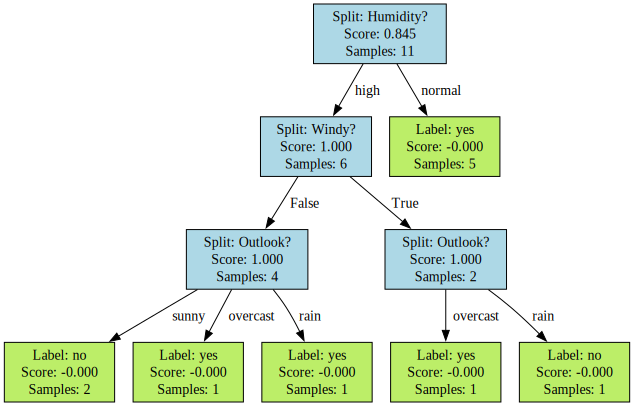

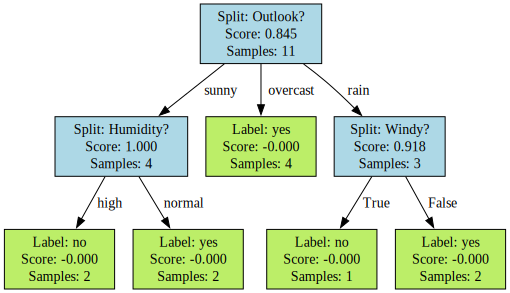

In [96]:
# Se construiește un arbore de decizie folosind algorithmul Random Tree
random_decision_tree = DecisionTree(split_strategy='random', 
                                    max_depth=MAX_DEPTH, 
                                    min_samples_per_node=MIN_SAMPLES_PER_NODE)

# Rulați această celulă de mai multe ori pentru a observa diferitele împărțiri ale arborelui
for _ in range(NUM_RUNS):
    random_decision_tree.fit(X_train, y_train)
    random_decision_tree.display()

Spre deosebire de Random Tree, algoritmul ID3 alege mereu aceeași împărțire a datelor, deoarece se bazează pe câștigul informațional.

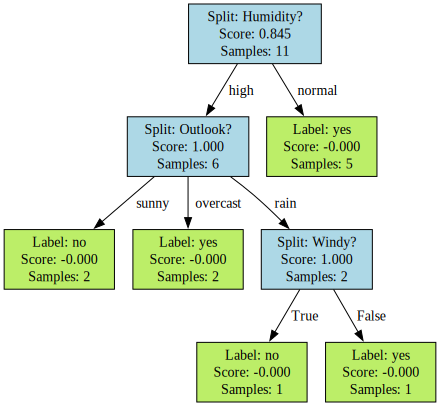

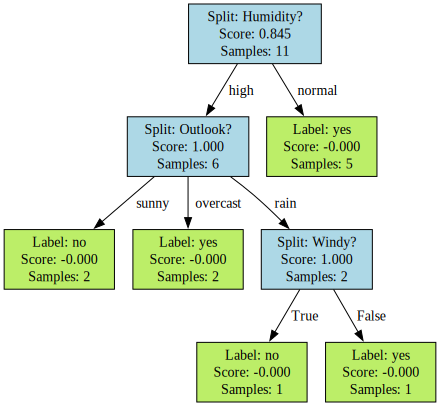

In [97]:
# Se construiește un arbore de decizie folosind algorithmul ID3
id3_decision_tree = DecisionTree(split_strategy='id3', 
                                 max_depth=MAX_DEPTH, 
                                 min_samples_per_node=MIN_SAMPLES_PER_NODE)
for _ in range(NUM_RUNS):
    id3_decision_tree.fit(X_train, y_train)
    id3_decision_tree.display()

Pentru setul de date *Tennis*, arborele de decizie construit folosind algoritmul ID3 pentru hiperparametrii *max_depth=3* și *min_samples_per_node=1* este:

![](res-id3/id3_tennis_example.png)

## Random Forest (Păduri de arbori aleatori)

Pădurile de arbori aleatori sunt o metodă de învățare supervizată în care se folosesc mai mulți arbori de decizie în 
procesul de clasificare. Clasificarea se face prin votul majorității arborilor. Această tehnică crește robustețea 
clasificatorului și reduce overfitting-ul.

Pentru a construi o pădure de arbori aleatori se urmează următorii pași:
1. Pentru fiecare arbore din pădure care se dorește a fi construit:
   1. Se alege un subset aleator din setul de date de antrenare
   2. Se aleg aleator $m$ atribute din setul de atribute inițial
   3. Se construiește un arbore de decizie pe subsetul de date ales
   4. Se adaugă arborele la pădure

Prin construirea arborilor pe subseturi aleatoare din setul de date, se obțin arbori diferiți.

### Discuții
* Porniți de la *n = 100*, *d = 3* și submulțimi formate din 50% din elementele lui X alese la întamplare și experimentați cu acești hiperparametrii.
* Comparați rezultatele obținute folosind un singur arbore construit cu ID3 și o pădure de arbori aleatori. Discuție după *zgomot*, *overfitting*.

In [102]:
class RandomForest:
    """
    Clasa care implementează un clasificator de tip pădure de arbori aleatori.
    """
    def __init__(self,
                 n_estimators: int = 100,
                 max_depth: int = 3,
                 min_samples_per_node: int = 1,
                 split_strategy: str = 'random',
                 subset_size_ratio: float = 0.5,
                 subset_feature_ratio: float = 0.75):
        """
        Constructor pentru un clasificator de tip pădure de arbori aleatori
        
        Args:
            n_estimators (int, optional): 
                Numărul de arbori din pădure. Defaults to 100.
            max_depth (int, optional): 
                Adâncimea maximă a fiecărui arbore. Defaults to 3.
            min_samples_per_node (int, optional): 
                Numărul minim de exemple dintr-un nod pentru a face o împărțire. 
                Defaults to 1.
            split_strategy (str, optional):
                Strategia folosită pentru alegerea împărțirii într-un nod. Aceasta poate fi:
                - 'id3' - alege împărțirea care maximizează câștigul informațional (folosind algoritmul ID3)
                - 'random' - alege aleator o împărțire
                Defaults to 'random'.
            subset_size_ratio (float, optional):
                Raportul de dimensiune al subsetului de date folosit pentru construirea fiecărui arbore comparativ cu
                dimensiunea setului de date inițial. Trebuie să fie un număr între 0 și 1.
                Defaults to 0.5.
            subset_feature_ratio (float, optional):
                Raportul de dimensiune al subsetului de atribute folosit pentru construirea fiecărui arbore comparativ cu
                dimensiunea setului de atribute inițial. Trebuie să fie un număr între 0 și 1.
                Defaults to 0.75.
        """
        assert 0 < subset_size_ratio <= 1, "subset_size_ratio must be between 0 and 1"
        assert 0 < subset_feature_ratio <= 1, "subset_feature_ratio must be between 0 and 1"
        
        self._trees: list[DecisionTree] = []
        self._n_estimators: int = n_estimators
        self._max_depth: int = max_depth
        self._min_samples_per_node: int = min_samples_per_node
        self._split_strategy: str = split_strategy
        self._subset_size_ratio: float = subset_size_ratio
        self._subset_feature_ratio: float = subset_feature_ratio
        
    def fit(self, X: pd.DataFrame, y: pd.Series):
        """
        Construiește pădurea de arbori aleatori pe baza setului de date
        
        Args:
            X (pd.DataFrame): 
                Setul de date (atributele)
            y (pd.Series): 
                Clasele corespunzătoare fiecărui exemplu din setul de date
        """
        # TODO 8. Construiți pădurea de arbori aleatori
        # Pentru a construi pădurea de arbori aleatori se vor parcurge următorii pași pentru fiecare estimator:
        #   1. Se alege un subset aleator din setul de date de antrenare. 
        #      Subsetul va conține un număr de exemple egal cu 
        #      `subset_size_ratio` * numărul de exemple din setul de date
        #   2. Se construiește un arbore de decizie pe subsetul de date
        #   3. Se adaugă arborele la pădure
        # HINT:
        #   Pentru a alege un subset aleator din setul de date puteți folosi funcția np.random.choice() pentru a selecta
        #   indicii exemplelor care vor fi folosiți în construcția arborelui. Indicii vor fi extrași fără înlocuire. 
        #   Exemplu:
        #       indices = np.random.choice(X.shape[0], size=int(self._subset_size_ratio * X.shape[0]), replace=False)
        #       X_subset = X.iloc[indices]  # Selectează doar exemplele cu indicii aleși (atributele rămân aceleași)
        #       y_subset = y.iloc[indices]
        #   Funcția `np.random.choice()` va selecta indicii aleator din intervalul [0, X.shape[0]) și va returna un subset
        #   de dimensiune `int(self._subset_size_ratio * X.shape[0])` cu indicii selectați.
        #   Indicii vor fi un np.ndarray de forma [0, 1, 2, 3, 5, 9, ...].
        #
        # HINT: 
        #   Pentru a extrage un subset de atribute puteți folosi următoarea expresie:
        #       X_subset = X[features]
        #   unde `features` este o listă cu numele atributelor pe care doriți să le folosiți
        self._trees = []
        for _ in range(self._n_estimators):
            # Se selectează un subset aleator din setul de date
            # Se selectează din X un subset de atribute
            # Se construiește un arbore de decizie pe subsetul de date
            # Se adaugă arborele la pădure
            indices = np.random.choice(
            X.shape[0],
            size=int(self._subset_size_ratio * X.shape[0]),
            replace=False
        )
            X_subset = X.iloc[indices]
            y_subset = y.iloc[indices]
        
            tree = DecisionTree(
            max_depth=self._max_depth,
            min_samples_per_node=self._min_samples_per_node,
            split_strategy='random'  # folosim împărțiri aleatoare pentru Random Forest
        )
            tree.fit(X_subset, y_subset)
            self._trees.append(tree)   

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        """
        Realizează predicția claselor pentru un set de date X
        
        Args:
            X (pd.DataFrame): Setul de date (atributele) pentru care se dorește clasificarea
            
        Returns:
            np.ndarray: Un vector cu clasele prezise pentru fiecare exemplu din X
        """
        predictions = []
        
        for tree in self._trees:
            predictions.append(tree.predict(X))
            
        # Se alege clasa majoritară pentru fiecare exemplu din setul de date
        return np.array([Counter(pred).most_common(1)[0][0] for pred in np.array(predictions).T])
    
    def display(self, max_trees: int = 5):
        """
        Afișează arborii din pădure
        
        Args:
            max_trees (int, optional): 
                Numărul maxim de arbori care vor fi afișați. Defaults to 5.
        
        Warnings:
            Afișarea arborilor nu este indicată pentru un număr mare de estimatori
        """
        for i, tree in enumerate(self._trees[:max_trees]):
            print()
            tree.display()

#### Exemplu de utilizare a clasei RandomForest

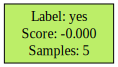

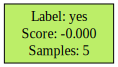

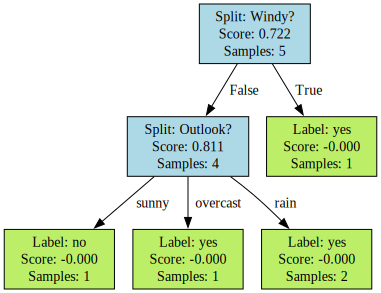

In [103]:
# Se construiește un clasificator de tip pădure de arbori aleatori
random_forest = RandomForest(n_estimators=3, 
                             max_depth=3, 
                             min_samples_per_node=MIN_SAMPLES_PER_NODE, 
                             split_strategy='id3')

# Se antrenează clasificatorul
random_forest.fit(X_train, y_train)

# Afișăm arborii creați
random_forest.display()

In [104]:
# Se realizează predicția claselor pentru setul de date de test
y_pred_rf = random_forest.predict(X_test)

print("Datele de intrare:")
print(X_test.iloc[0])

print("\nClasa reală:")
print(y_test.iloc[0])

print("\nClasa prezisă:")
print(y_pred_rf[0])

Datele de intrare:
Outlook          rain
Temperature      cool
Humidity       normal
Windy            True
Name: 5, dtype: object

Clasa reală:
no

Clasa prezisă:
yes


## Evaluarea modelelor

Un exemplu clasificat poate aparține unei clase pozitive sau negative și poate fi clasificat corect sau greșit de un model de clasificare. În funcție de aceste două caracteristici, un exemplu poate fi clasificat în una din cele patru categorii:
* **True Positive (TP)**: exemplu pozitiv clasificat corect
* **True Negative (TN)**: exemplu negativ clasificat corect
* **False Positive (FP)**: exemplu negativ clasificat greșit
* **False Negative (FN)**: exemplu pozitiv clasificat greșit

$$ 
    TP = True\ Positives\\
    FP = False\ Positives\\
    TN = True\ Negatives\\
    FN = False\ Negatives\\
$$

Pentru a evalua modelele de clasificare vom folosi următoarele metrici:
* **Acuratețe (Accuracy)**: reprezintă raportul între numărul de exemple clasificate corect și numărul total de exemple din setul de date.
* **Precizie (Precision)**: reprezintă raportul între numărul de exemple clasificate corect cu clasa `c` și numărul total de exemple clasificate cu clasa `c`.
* **Acoperire (Recall)**: reprezintă raportul între numărul de exemple clasificate corect cu clasa `c` și numărul total de exemple din setul de date cu clasa `c`.
* **Scorul F1 (F1 Score)**: reprezintă media armonică între precizie și acoperire.

$$
    accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

$$
    precision = \frac{TP}{TP + FP}
$$

$$
    recall = \frac{TP}{TP + FN}
$$

$$
    f1\_score = 2 \cdot \frac{precision \cdot recall}{precision + recall}
$$

De asemenea, pentru a evalua corectitudinea modelelor de clasificare vom folosi următoarele concepte:
* **Matrice de confuzie (Confusion Matrix)**: este o matrice care arată numărul de exemple clasificate corect și numărul de exemple clasificate greșit pentru fiecare clasă.


$$
    \begin{array}{|c|c|c|}
    \hline
    & \text{Predicție pozitivă} & \text{Predicție negativă} \\
    \hline
    \text{Clasa pozitivă} & TP & FN \\
    \hline
    \text{Clasa negativă} & FP & TN \\
    \hline
    \end{array}
$$

In [105]:
def precision(y_pred: pd.Series, y_true: pd.Series, c: str) -> float:
    """
    Calculează precizia (precision) unui clasificator. 
    Precizia este definită ca raportul între numărul de exemple clasificate corect cu clasa `c` și numărul total de exemple clasificate cu clasa `c`.
    
    Args:
        y_pred (pd.Series): 
            Clasele prezise de clasificator
        y_true (pd.Series): 
            Clasele reale din setul de date
        c (str):
            Clasa pentru care se calculează precizia

    Returns:
        float: 
            Precizia clasificatorului
            
    Examples:
    --------
    >>> precision(y_pred=pd.Series(['a', 'a', 'a', 'a', 'b']), 
    >>>           y_true=pd.Series(['a', 'a', 'a', 'b', 'b']), 
    >>>           c='a')
    0.75
    """
    # Doar exemplele clasificate cu clasa c sunt relevante pentru calculul preciziei
    pred_c = y_pred[y_pred == c]
    
    # Extrage doar exemplele clasificate corect cu clasa c
    true_c = y_true[(y_pred == c) & (y_true == c)]
    
    # Calculul preciziei
    if len(pred_c) == 0:
        return 0
    else:
        return len(true_c) / len(pred_c)
    
def recall(y_pred: pd.Series, y_true: pd.Series, c: str) -> float:
    """
    Calculează acoperirea (recall) unui clasificator. 
    Acoperirea este definită ca raportul între numărul de exemple clasificate corect cu clasa `c` și numărul total de exemple din setul de date cu clasa `c`.
    
    Args:
        y_pred (pd.Series): 
            Clasele prezise de clasificator
        y_true (pd.Series): 
            Clasele reale din setul de date
        c (str): 
            Clasa pentru care se calculează acoperirea

    Returns:
        float: 
            Acoperirea clasificatorului
            
    Examples:
    --------
    >>> recall(y_pred=pd.Series(['a', 'a', 'a', 'a', 'b']),
    >>>        y_true=pd.Series(['a', 'a', 'a', 'b', 'b']),
    >>>        c='a')
    1.0     
    """
    # Doar exemplele din setul de date cu clasa c sunt relevante pentru calculul acoperirii
    true_c = y_true[y_true == c]
    
    # Extrage doar exemplele clasificate corect cu clasa c
    pred_c = y_pred[(y_pred == c) & (y_true == c)]
    
    # Calculul acoperirii
    if len(true_c) == 0:
        return 0
    else:
        return len(pred_c) / len(true_c)
    
def f1_score(y_pred: pd.Series, y_true: pd.Series, c: str) -> float:
    """
    Calculează scorul F1 al unui clasificator. 
    Scorul F1 este definit ca media armonică între precizie și acoperire.
    
    Args:
        y_pred (pd.Series): 
            Clasele prezise de clasificator
        y_true (pd.Series): 
            Clasele reale din setul de date
        c (str):
            Clasa pentru care se calculează scorul F1

    Returns:
        float: 
            Scorul F1 al clasificatorului
            
    Examples:
    --------
    >>> f1_score(y_pred=pd.Series(['a', 'a', 'a', 'a', 'b']),
    >>>           y_true=pd.Series(['a', 'a', 'a', 'b', 'b']),
    >>>           c='a')
    0.8571428571428571
    """
    # Calculul scorului F1
    p = precision(y_pred, y_true, c)
    r = recall(y_pred, y_true, c)
    
    if p + r == 0:
        return 0
    else:
        return 2 * p * r / (p + r)
    
def accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:
    """
    Calculează acuratețea unui clasificator. 
    Acuratețea este definită ca raportul între numărul de exemple clasificate corect și numărul total de exemple din setul de date.
    
    Args:
        y_pred (pd.Series): 
            Clasele prezise de clasificator
        y_true (pd.Series): 
            Clasele reale din setul de date

    Returns:
        float: 
            Acuratețea clasificatorului
            
    Examples:
    --------
    >>> accuracy(pd.Series(['a', 'a', 'a', 'a', 'b']), pd.Series(['a', 'a', 'a', 'b', 'b']))
    0.8
    """
    # Calculul acurateței
    return (y_pred == y_true).sum() / len(y_true)

def evaluate(tree: DecisionTree, X: pd.DataFrame, y: pd.Series):
    """
    Evaluează un arbore de decizie / pădure de arbori de decizie pe un set de date X.
    Pentru evaluare se va folosi de funcția `predict` a arborelui de decizie / pădurii de arbori de decizie.
    
    Rezultatul va fi un tabel cu metricile de evaluare: acuratețe, precizie, recall, f1-score.
        
    Args:
        tree (DecisionTreeNode): 
            Arborele de decizie / pădurea de arbori de decizie
        X (pd.DataFrame): 
            Setul de date (atributele) pentru care se dorește clasificarea
        y (pd.Series):
            Clasele corespunzătoare fiecărui exemplu din setul de date
    Examples
    --------
    >>> evaluate(tree, X_test)
                  precision    recall  f1-score   support

             acc       0.61      0.73      0.66        90
            good       0.00      0.00      0.00        11
           unacc       0.91      0.92      0.92       231
           vgood       0.00      0.00      0.00        14
    
        accuracy                           0.81       346
       macro avg       0.38      0.41      0.39       346
    weighted avg       0.77      0.81      0.78       346
    """
    from sklearn.metrics import classification_report

    y_pred = tree.predict(X)
    print(classification_report(y, y_pred, zero_division=0))
    
def plot_confusion_matrix(y_pred: pd.Series, y_true: pd.Series):
    """
    Construiește matricea de confuzie pentru un clasificator.
    
    Args:
        y_pred (pd.Series): 
            Clasele prezise de clasificator
        y_true (pd.Series): 
            Clasele reale din setul de date
    """
    confusion_matrix = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'], dropna=False)

    # Adăugăm toate clasele prezise și reale pentru a avea toate clasele în matricea de confuzie
    all_classes = np.unique(list(y_true) + list(y_pred))
    confusion_matrix = confusion_matrix.reindex(index=all_classes, columns=all_classes, fill_value=0)

    print(confusion_matrix)
    
    plt.figure(figsize=(10,7))
    sns.heatmap(confusion_matrix, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

In [106]:
# Selectam setul de date Chess pentru evaluare, deoarece acesta are mai multe exemple
data_cars = load_dataset('chess')
X_train, y_train, X_test, y_test = split_train_test(data_cars, "class", test_size=0.2)

print("Train set size: ", len(X_train))
print("Test set size: ", len(X_test))
print("Number of classes: ", y_train.nunique())
print("Number of features: ", len(X_train.columns))

print("\nNumber of examples per class in train set:")
print(y_train.value_counts())

Dataset: chess
Train set size:  2556
Test set size:  640
Number of classes:  2
Number of features:  36

Number of examples per class in train set:
class
won      1328
nowin    1228
Name: count, dtype: int64


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.09s/it]


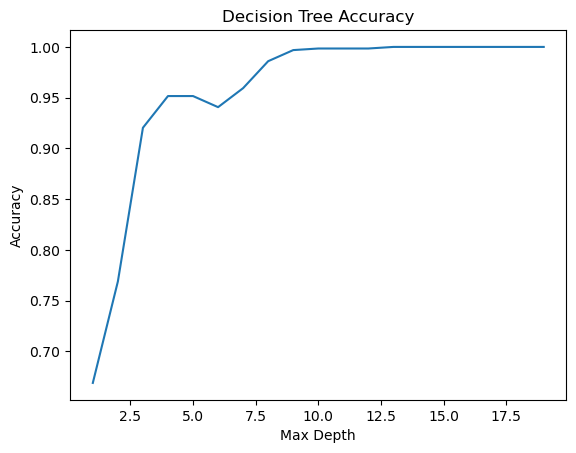

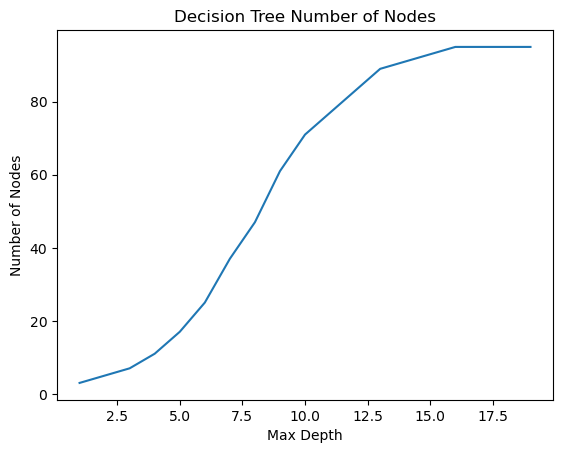

In [107]:
# Analizăm influența parametrului `max_depth` asupra performanței clasificatorului Decision Tree
max_depth_values = list(range(1, 20))

accuracies = []
num_nodes = []

for max_depth in tqdm(max_depth_values):
    decision_tree = DecisionTree(split_strategy='id3', 
                                 max_depth=max_depth, 
                                 min_samples_per_node=2)
    decision_tree.fit(X_train, y_train)
    accuracies += [accuracy(decision_tree.predict(X_test), y_test)]
    num_nodes += [decision_tree.get_number_of_nodes()]
    
# Afișăm graficul cu acuratețea clasificatorului în funcție de adâncimea maximă a arborelui
plt.plot(max_depth_values, accuracies)
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy')
plt.show()

# Afișăm graficul cu numărul de noduri din arbore în funcție de adâncimea maximă a arborelui
plt.plot(max_depth_values, num_nodes)
plt.xlabel('Max Depth')
plt.ylabel('Number of Nodes')
plt.title('Decision Tree Number of Nodes')
plt.show()

Creșterea adâncimii arborelui de decizie duce la creșterea acurateței clasificatorului pe setul de date de test, până
 la un anumit punct, după care acuratețea se stabilizează. Acest lucru se datorează faptului că arborele a ajuns
 la o adâncime la care a învățat toate exemplele din setul de date de antrenare.
    
În mod normal, creșterea adâncimii arborelui de decizie duce la creșterea complexității modelului, ceea ce poate duce la
 overfitting. Overfitting-ul apare atunci când modelul învață prea bine setul de date de antrenare și nu generalizează
 corect pe setul de date de test.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.45it/s]


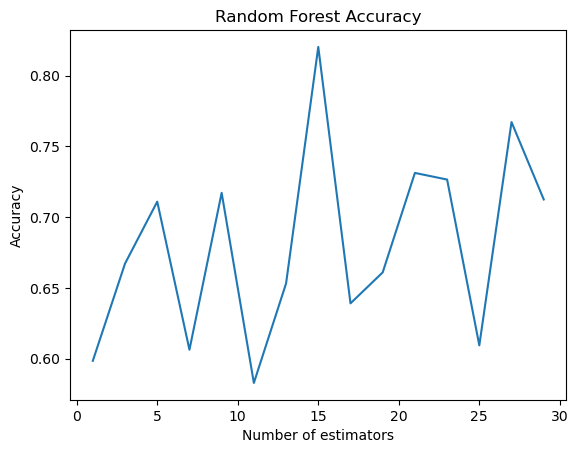

In [108]:
# Analizăm influența parametrului `n_estimators` asupra performanței clasificatorului Random Forest
n_estimators_values = list(range(1, 31, 2))

accuracies = []

for n_estimators in tqdm(n_estimators_values):
    random_forest = RandomForest(n_estimators=n_estimators, 
                                 max_depth=3, 
                                 min_samples_per_node=2, 
                                 split_strategy='id3')
    random_forest.fit(X_train, y_train)
    accuracies += [accuracy(random_forest.predict(X_test), y_test)]
    
plt.plot(n_estimators_values, accuracies)
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy')
plt.show()

După cum se poate observa, creșterea numărului de estimatori din pădurea de arbori aleatori duce la creșterea 
acurateței clasificatorului până la un anumit punct, după care acuratețea se stabilizează, iar creșterea numărului de
 estimatori nu mai aduce beneficii semnificative. Din acest motiv, este important să alegem un număr optim de 
 estimatori pentru a obține un echilibru între performanță și timp de antrenare.


In [109]:
# Comparăm rezultatele obținute folosind un singur arbore construit cu ID3 și o pădure de arbori aleatori
id3_decision_tree = DecisionTree(split_strategy='id3', 
                                 max_depth=100, 
                                 min_samples_per_node=2)
random_forest = RandomForest(n_estimators=50, 
                             max_depth=3, 
                             min_samples_per_node=2, 
                             split_strategy='id3')

id3_decision_tree.fit(X_train, y_train)
random_forest.fit(X_train, y_train)

print("ID3 Decision Tree:")
evaluate(id3_decision_tree, X_test, y_test)

print("\nRandom Forest:")
evaluate(random_forest, X_test, y_test)

ID3 Decision Tree:
              precision    recall  f1-score   support

       nowin       1.00      1.00      1.00       299
         won       1.00      1.00      1.00       341

    accuracy                           1.00       640
   macro avg       1.00      1.00      1.00       640
weighted avg       1.00      1.00      1.00       640


Random Forest:
              precision    recall  f1-score   support

       nowin       0.88      0.42      0.57       299
         won       0.65      0.95      0.77       341

    accuracy                           0.70       640
   macro avg       0.77      0.68      0.67       640
weighted avg       0.76      0.70      0.68       640



Predicted  nowin  won
Actual               
nowin        299    0
won            0  341


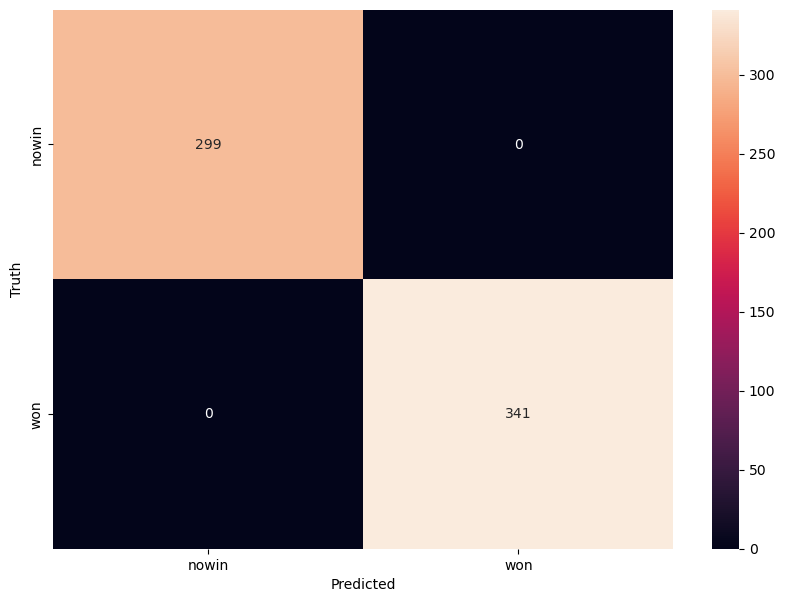

In [110]:
plot_confusion_matrix(id3_decision_tree.predict(X_test), y_test)

Predicted  nowin  won
Actual               
nowin        125  174
won           17  324


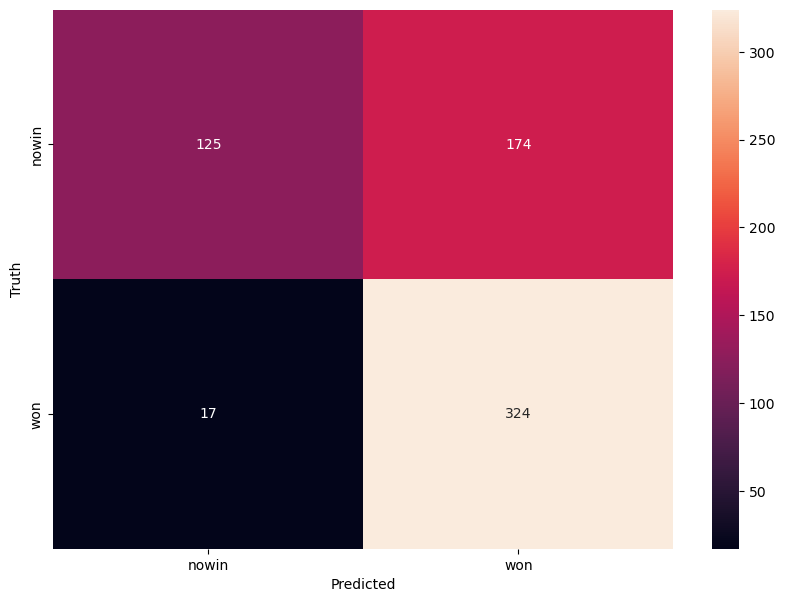

In [111]:
plot_confusion_matrix(random_forest.predict(X_test), y_test)

### Comparare cu implementarea din biblioteca `sklearn`

`sklearn` oferă o implementări pentru arborele de decizie și pădurea de arbori aleatori. În această secțiune vom compara rezultatele obținute folosind implementările noastre cu cele din bibliotecă.

Spre deosebire de implementarea noastră, arborii din `sklearn` nu suportă variabile categorice. Din acest motiv, vom converti variabilele categorice în variabile numerice, folosind funcția `pd.get_dummies()` care realizează codificarea one-hot (*one-hot encoding*).

#### One-Hot Encoding

One-Hot Encoding este o tehnică de preprocesare a datelor care transformă variabilele categorice în variabile numerice. Această tehnică constă în crearea unui nou atribut pentru fiecare valoare a variabilei categorice, atribut care va avea valoarea 1 dacă exemplul aparține acelei categorii și 0 în caz contrar.

**Exemplu:**

Avem atributul categoric `Color` cu valorile `Red`, `Green`, `Blue`. După aplicarea One-Hot Encoding, atributul `Color` va fi înlocuit de 3 atribute: `Color_Red`, `Color_Green`, `Color_Blue`.

&nbsp;

<center>

<table>

<tr> 
    <td> Setul de date inițial </td> 
    <td> Setul de date Once-Hot Encoded </td> 
</tr>

<tr> <td>

| Color |
|-------|
| Red   |
| Green |
| Blue  |
| Red   |

</td> <td>

| Color_Red | Color_Green | Color_Blue |
|-----------|-------------|------------|
| 1         | 0           | 0          |
| 0         | 1           | 0          |
| 0         | 0           | 1          |
| 1         | 0           | 0          |

</td></tr> </table>

</center>

In [112]:
# Convertim variabilele categorice în variabile numerice folosind One-Hot Encoding
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# Setul de antrenare poate conține alte valori ale atributelor față de setul 
# de date de test, ceea ce poate duce la un număr diferit de atribute 
# în cele două seturi după aplicarea One-Hot Encoding.
# Vom completa seturile de date cu coloane lipsă
X_train_encoded = X_train_encoded.reindex(columns=X_test_encoded.columns, fill_value=0)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

print("Number of features in train set after encoding: ", len(X_train_encoded.columns))
print("Number of features in test set after encoding: ", len(X_test_encoded.columns))

Number of features in train set after encoding:  72
Number of features in test set after encoding:  72


Decision Tree (sklearn):
              precision    recall  f1-score   support

       nowin       1.00      1.00      1.00       299
         won       1.00      1.00      1.00       341

    accuracy                           1.00       640
   macro avg       1.00      1.00      1.00       640
weighted avg       1.00      1.00      1.00       640

Predicted  nowin  won
Actual               
nowin        299    0
won            0  341


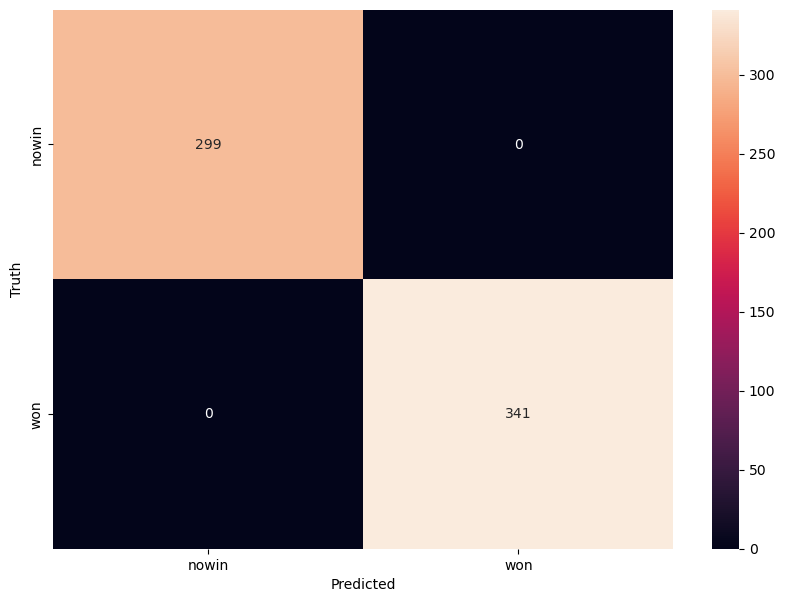

In [113]:
from sklearn.tree import DecisionTreeClassifier

# Antrenăm un arbore de decizie folosind implementarea din `sklearn`
sklearn_decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=100)
sklearn_decision_tree.fit(X_train_encoded, y_train)

# Evaluăm arborele de decizie
print("Decision Tree (sklearn):")
evaluate(sklearn_decision_tree, X_test_encoded, y_test)

# Afișăm matricea de confuzie
plot_confusion_matrix(sklearn_decision_tree.predict(X_test_encoded), y_test)

Random Forest (sklearn):
              precision    recall  f1-score   support

       nowin       0.96      0.94      0.95       299
         won       0.95      0.96      0.96       341

    accuracy                           0.95       640
   macro avg       0.95      0.95      0.95       640
weighted avg       0.95      0.95      0.95       640

Predicted  nowin  won
Actual               
nowin        282   17
won           13  328


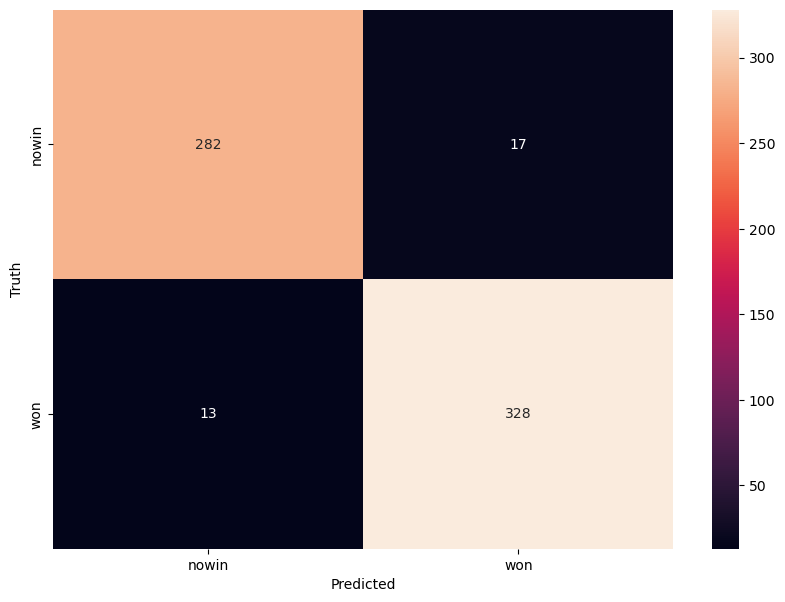

In [114]:
from sklearn.ensemble import RandomForestClassifier

# Antrenăm o pădure de arbori aleatori folosind implementarea din `sklearn`
sklearn_random_forest = RandomForestClassifier(n_estimators=50, max_depth=3)
sklearn_random_forest.fit(X_train_encoded, y_train)

# Evaluăm pădurea de arbori aleatori
print("Random Forest (sklearn):")
evaluate(sklearn_random_forest, X_test_encoded, y_test)

# Afișăm matricea de confuzie
plot_confusion_matrix(sklearn_random_forest.predict(X_test_encoded), y_test)

## Extra informații

### ID3 exemplu
Un exemplu mai detaliat pentru construcția arborelui de decizie ID3 se poate găsi [aici](https://github.com/cs-pub-ro/ML/blob/master/lab/lab2/id3_example.pdf).

### CART
Un alt algoritm utilizat poartă denumirea de CART (eng. Classification and Regression Tree). Dacă **ID3** utilizeaza **câștigul informațional (eng. information gain)**, **CART** utilizeaza o altă metrică numită **index-ul Gini (eng. Gini index sau Gini impurity)**.

Pentru implementare, se urmăresc exact aceeași [pași ca la ID3](#scrollTo=rjYqUPSbe1gG), singura diferentă fiind modul în care se calculează atributul utilizat într-un *nod intermediar*.
$$
Gini(X, a) = 1 - \sum_{c \in C}{p(c | attr(X) = a) ^2}
\\
a^* = \underset{a \in A}{\operatorname{arg min}}\ Gini(X, a)
$$